# Blog Post 3: Color Transfer, UNet, and Semantic Segmentation Work

In this post, we'll go over the following key points:

1. comment on what we're doing to handle modalities
1. discuss our network for improved pixel classification
1. discuss our work on the task of semantic segmentation and how we can improve it moving forward

### reading data and preprocessing

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 150

import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from deton8.utils import DataReader
from sklearn.model_selection import train_test_split

training = DataReader("../data/training/")
train_metadata, x_train = training.get(skip=10)

y_train = np.stack(training.masks)
train_metadata, val_metadata, x_train, x_val, y_train, y_val = train_test_split(train_metadata, x_train, y_train, train_size = 0.8)

/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Color Transfer

Over the past few months and years, there's been a rise in publications involving neural style transfer, many of which who employ deep neural networks to transfer the *style* of one image to the *content* of another.  We initially took this approach, attempting to transfer the dark background and light nuclei style of several of the training images to some of the more difficult training images with lighter back grounds.  Unfortunately, in practice this proved be to be far too resource demanding and time consuming.  

However, we didn't need full style transfer, simply color transfer!  Note that the color of an image is simply defined as the ratio of the red green and blue color channels of an image.  There exists well known methods of transfering the color of a given image or a set of images to the content of another image.  Typically, one computes the covariance matrix w.r.t. channels of the image.  From here, several methods can ensue, but all depend on creating some sort of decomposition of the covariance matrix such as PCA.  Of course, a decomposition may or may not result in dimensionality reduction.  Our implementation employs PCA so that we develop basis transformations that maximize the variance of each projected channel.

Here's the idea: given a covariance matrix for an image, $A$, with the desired color content and a covariance matrix for an image, $B$, with the desired content, decompose both into invertible representations.  Then, take the existing channel content, multiply it by the inverse of the decomposition of $B$, and finally multiply by it by the decomposition of $A$.  Intuitively (and very hand-wavy), we're "reversing" the effect of the coloring processing on the image content and then applying our desired image color content to the image content.  Very elegant.  Let's see how it works.

In [4]:
from deton8.visualization import plot_color_transfer_results

### choosing the desired style images

Currently we just choose these empirically.  Moving forward we'll probably employ some form of $k$-means clustering to choose the images.

In this batch, the following are good: [1, 7, 8, 9].  Should be enough to get good results on the rest of the images.

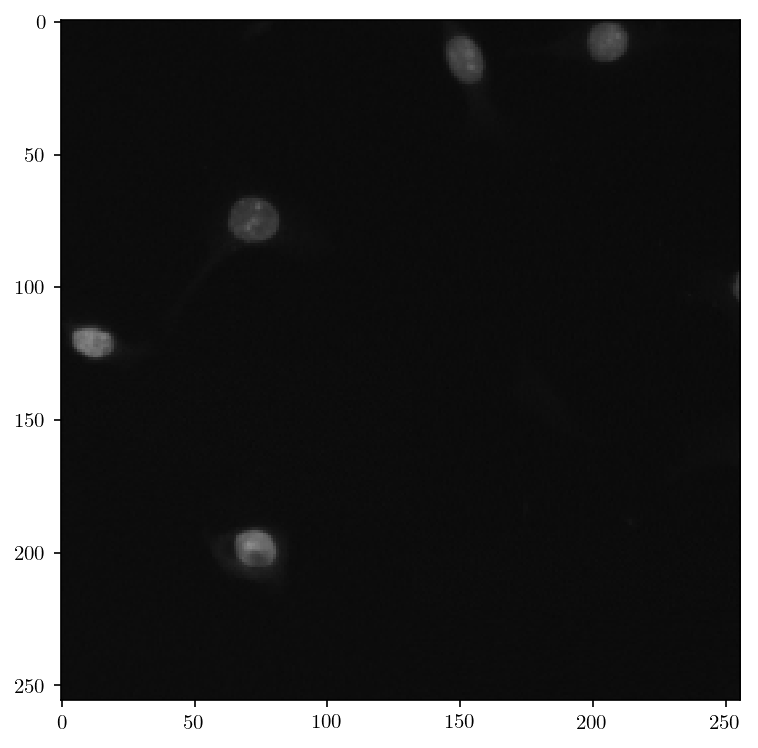

In [17]:
plt.imshow(x_train[4])

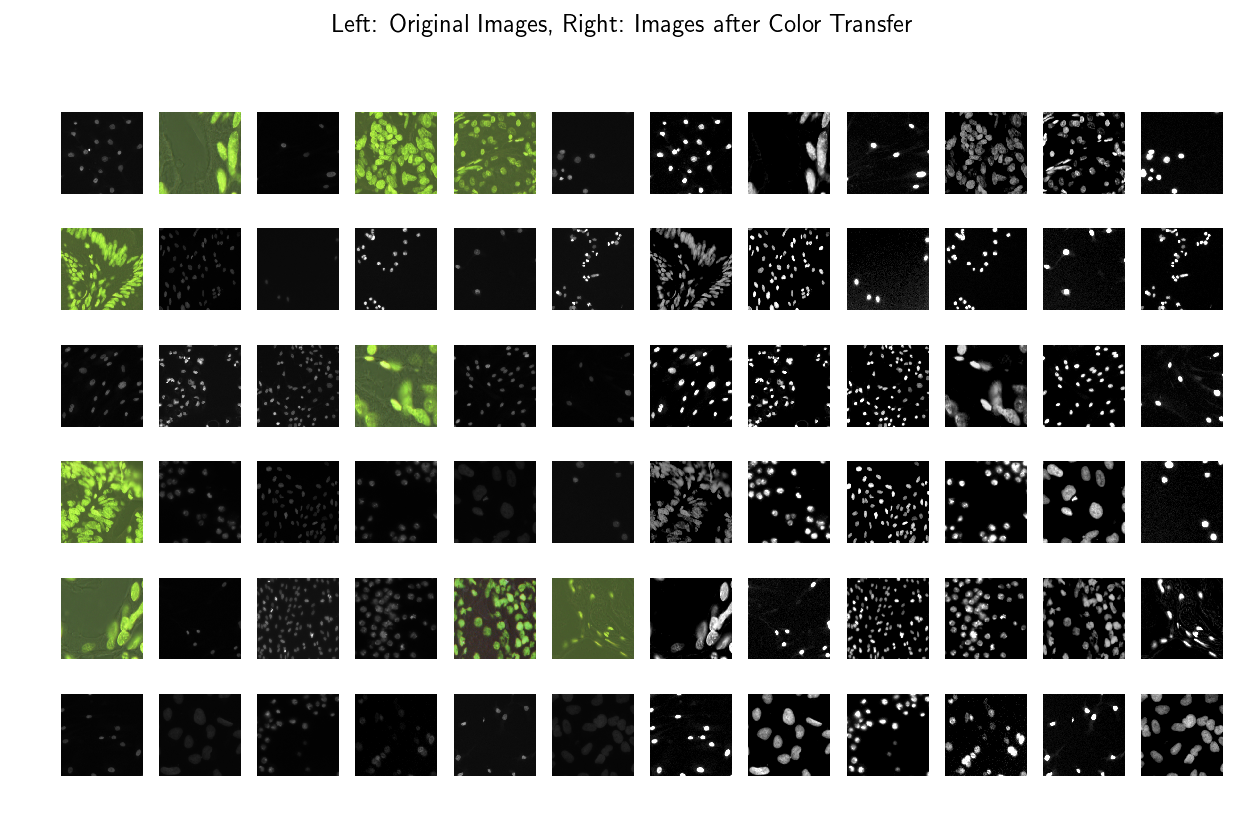

In [18]:
plot_color_transfer_results(trainImages=x_train, style_indices=np.array([0, 3, 5, 7, 8]), grid_size=(6, 6))

## comment on quality of results

Note that there are two desirable effects of this transformation.  Firstly the intended effect of handling the other modalities than white on a black background and secondly an effective constrast increase to the style modality.  Observe that the images in green on the left half of the plot above have beecome completely black and white at locations of nuclei on the right, as desired.

We believe our approach to handling the image modalities will be a vital part of training a simple classifier for this problem, as well as managing the stage 2 test dataset.

# UNet
By qualitative inspection, we recognized that the `Passive Aggressive Regressor` and `SGD Regressor` both did well on most datasets, with each model performing better than the other on certain images. Thus, we decided to create a `UNet` with these regressors' outputs as the pixel features. Below we stack these regressors' outputs as features and preprocess the data:

In [19]:
from deton8.preprocess import preprocess
x_train_extended = preprocess(x_train)
x_val_extended = preprocess(x_val)

100%|██████████| 14/14 [00:00<00:00, 28.84pair/s]


In [20]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We chose to perform data augmentation so as to prevent or reduce the liklihood of overfitting.  This was done using the quite useful keras ImageDataGenerator api.

In [21]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

For metrics, we decided to use pixel-wise dice coefficient and F1. We also describe the architecture of the UNet Below

In [22]:
def dice_coef(y_true, y_pred):
    smooth = .1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

input_layer = Input(shape=x_train_extended.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_regress = Model(input_layer, output_layer)

For the UNet, we decided to use the negative dice coefficient as loss with RMSProp for optimization

In [23]:
import tensorflow as tf
def dice_coef_loss(y_true, y_pred):
    return -1*dice_coef(y_true, y_pred)

model_regress.compile(optimizer=RMSprop(0.0002), loss=dice_coef_loss, metrics=[dice_coef, f1])

In [24]:
hist = model_regress.fit_generator(my_generator(x_train_extended, np.expand_dims(y_train, axis = 3), 8),
                           steps_per_epoch = 25,
                           validation_data = (x_val_extended, np.expand_dims(y_val, axis = 3)),
                           epochs=10, verbose=True)

Epoch 1/10


/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/site-packages/keras/preprocessing/image.py:857: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (53, 256, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


25/25 [==============================] - 47s 2s/step - loss: -0.2223 - dice_coef: 0.2223 - f1: 0.5092 - val_loss: -0.2546 - val_dice_coef: 0.2546 - val_f1: 0.8270
Epoch 2/10
25/25 [==============================] - 45s 2s/step - loss: -0.2768 - dice_coef: 0.2768 - f1: 0.7199 - val_loss: -0.4212 - val_dice_coef: 0.4212 - val_f1: 0.7972
Epoch 3/10
25/25 [==============================] - 47s 2s/step - loss: -0.5506 - dice_coef: 0.5506 - f1: 0.7685 - val_loss: -0.7356 - val_dice_coef: 0.7356 - val_f1: 0.8052
Epoch 4/10
25/25 [==============================] - 45s 2s/step - loss: -0.7264 - dice_coef: 0.7264 - f1: 0.7872 - val_loss: -0.7915 - val_dice_coef: 0.7915 - val_f1: 0.8125
Epoch 5/10
25/25 [==============================] - 48s 2s/step - loss: -0.7725 - dice_coef: 0.7725 - f1: 0.8010 - val_loss: -0.8068 - val_dice_coef: 0.8068 - val_f1: 0.8179
Epoch 6/10
25/25 [==============================] - 46s 2s/step - loss: -0.7937 - dice_coef: 0.7937 - f1: 0.8107 - val_loss: -0.8165 - val_di

For segmentation, we decided to use a common segmentation algorithm known as the watershed algorithm.  It works on a binary image mask by first computing a distance transform of an image (distance to the nearest edge) followed by identifying local extrema.  Using an existing implementation of Non-Maximum-Suppression, we identified these local extrema.  We followed this up by some decision heuristics to limit the risk of oversegmentation.  Below are the results of our pipeline.

In [25]:
from deton8.visualization import plot_segmentation
from deton8.pipeline import postprocess

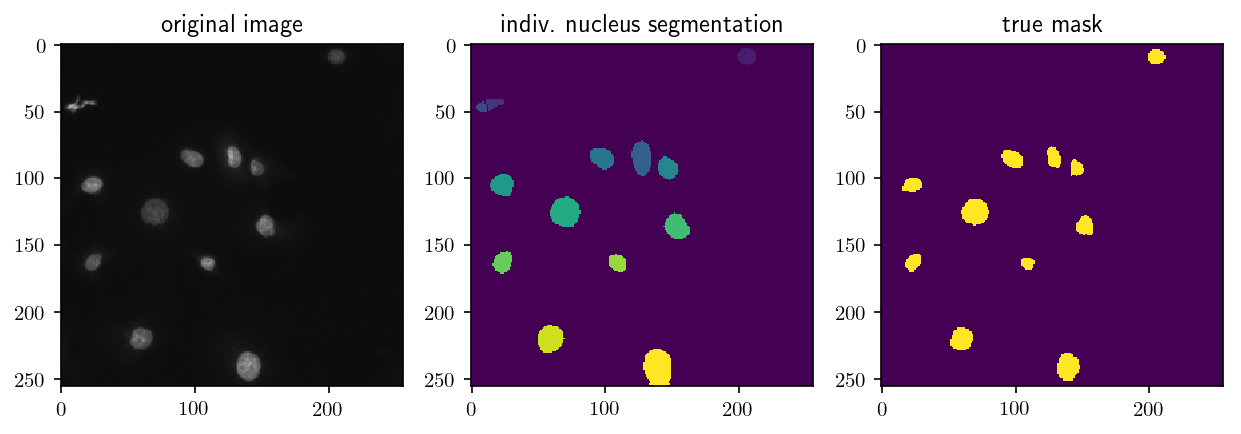

In [38]:
num = 5
feat = x_val[num]
pred = postprocess(model_regress.predict(np.expand_dims(x_val_extended[num], axis=0)), min_area=10) > 0
true = y_val[num]
plot_segmentation(feat, pred, true)